# Transfer Learning on ResNet50 model

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import keras
import tensorflow
import PIL
import glob
import numpy as np
import pandas as pd
import os
import shutil 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize

Using TensorFlow backend.


In [2]:
excel_sheet=pd.read_csv('ML_Features_1144.csv')


In [3]:
required_dftrain=excel_sheet[['sr_no','image_name','classification']]
#required_df.replace('Non-Viable-Tumor','Non-Tumor')
# required_df.replace(to_replace='Non-Viable-Tumor', value='Non-Tumor', regex=True)
# required_df.replace(to_replace='Viable', value='Tumor', regex=True)
# required_df.replace(to_replace='viable:non-viable', value='Tumor', regex=True)
#required_df.replace('Viable','Tumor')
#required_df.replace('viable:non-viable','Tumor')
# required_dftest=required_df[0:547:1]
# required_dftrain=required_df[547:1144:1]

In [4]:
X_inc = [ ] # creating an empty array
i=0
loca=[]
for img_name in required_dftrain.image_name:
    try:
        frame_name=''+img_name
        loca.append(i)
        i=i+1
        img = plt.imread((frame_name+'.jpg').strip())
        X_inc.append(img)  # storing each image in array X
    except:
        i=i+1
        continue
X_inc = np.array(X_inc)    # converting list to array



#dummy_yresnet = np_utils.to_categorical(y_resnet)

image_inc = []
for i in range(0,X_inc.shape[0]):
    a_inc = resize(X_inc[i], preserve_range=True, output_shape=(150,150)).astype(int)      # reshaping to 150*150*3
    image_inc.append(a_inc)
X_inc = np.array(image_inc)

In [5]:
y_inc = required_dftrain.classification
ydash=[]
locat=np.array(loca)
for j in locat:
    try: 
        ydash.append(y_inc[j])
    except:
        continue
    
        
np.array(ydash)


array(['Non-Tumor', 'Non-Tumor', 'Non-Tumor', ..., 'Non-Tumor',
       'Non-Tumor', 'Non-Tumor'], dtype='<U9')

In [6]:
len(ydash)

1144

In [7]:
from sklearn.model_selection import train_test_split
X_traininc, X_validinc, y_traininc, y_validinc = train_test_split(X_inc, y_inc, test_size=0.3, random_state=42)    # preparing the validation set

train_imgs_scaled = X_traininc.astype('float32')
validation_imgs_scaled  = X_validinc.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_traininc)
train_labels_enc = le.transform(y_traininc)
validation_labels_enc = le.transform(y_validinc)

In [8]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(150,150,3))
output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)
restnet = Model(restnet.input, output=output)
for layer in restnet.layers:
    layer.trainable = False
restnet.summary()

C:\Users\HP\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  import sys


In [9]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
model = Sequential()
model.add(restnet)
model.add(Dense(512, activation='relu', input_dim=(150,150,3)))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
#opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])
model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 51200)             23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 50,065,793


In [10]:
np.random.seed(1337)
#image augmentation
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(X_traininc, train_labels_enc, batch_size=12)
val_generator = val_datagen.flow(X_validinc, validation_labels_enc, batch_size=12)
history = model.fit_generator(train_generator, 
                              steps_per_epoch=10, 
                              epochs=35,
                              validation_data=val_generator, 
                              validation_steps=20, 
                              verbose=1)



Epoch 1/35
10/10 [==============================] - 32s 3s/step - loss: 0.2356 - acc: 0.7000 - val_loss: 0.3174 - val_acc: 0.3375
Epoch 2/35
10/10 [==============================] - 11s 1s/step - loss: 0.1887 - acc: 0.7917 - val_loss: 0.3451 - val_acc: 0.2924
Epoch 3/35
10/10 [==============================] - 10s 967ms/step - loss: 0.2359 - acc: 0.7167 - val_loss: 0.3667 - val_acc: 0.2966
Epoch 4/35
10/10 [==============================] - 10s 977ms/step - loss: 0.1673 - acc: 0.8000 - val_loss: 0.3512 - val_acc: 0.3125
Epoch 5/35
10/10 [==============================] - 10s 968ms/step - loss: 0.2387 - acc: 0.7167 - val_loss: 0.2984 - val_acc: 0.3517
Epoch 6/35
10/10 [==============================] - 10s 969ms/step - loss: 0.1295 - acc: 0.8250 - val_loss: 0.3460 - val_acc: 0.2669
Epoch 7/35
10/10 [==============================] - 10s 969ms/step - loss: 0.1737 - acc: 0.7621 - val_loss: 0.2296 - val_acc: 0.6583
Epoch 8/35
10/10 [==============================] - 10s 970ms/step - loss

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


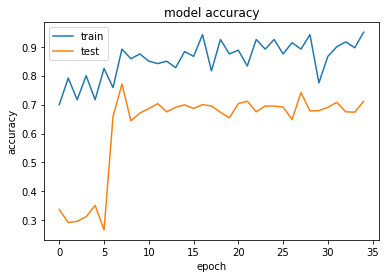

In [13]:
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

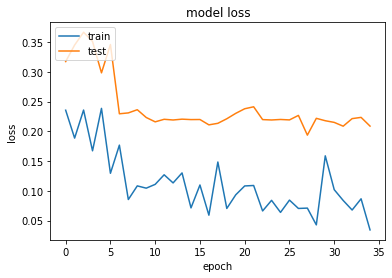

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Full Training ResNet50 model(done in Google Colab)

In [15]:
# full training of resnet50
#resize the images to 224*224*3
X_incfull = [ ] # creating an empty array
i=0
loca=[]
for img_name in required_dftrain.image_name:
    try:
        frame_name=''+img_name
        loca.append(i)
        i=i+1
        img = plt.imread((frame_name+'.jpg').strip())
        X_incfull.append(img)  # storing each image in array X
    except:
        i=i+1
        continue
X_incfull = np.array(X_incfull)    # converting list to array



#dummy_yresnet = np_utils.to_categorical(y_resnet)

image_incfull = []
for i in range(0,X_incfull.shape[0]):
    a_incfull = resize(X_incfull[i], preserve_range=True, output_shape=(224,224)).astype(int)      # reshaping to 224*224*3
    image_incfull.append(a_incfull)
X_incfull = np.array(image_incfull)




In [16]:
from keras.preprocessing.image import image
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.resnet50 import ResNet50


In [91]:
# modelresnet=ResNet50(weights='imagenet')
# pred=modelresnet.fit(img)

In [17]:
from keras.models import Model
import keras
modelrestnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
output = modelrestnet.layers[-1].output
output = keras.layers.Flatten()(output)
modelrestnet = Model(modelrestnet.input, output=output)
for layer in modelrestnet.layers:
    layer.trainable = True


from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
model = Sequential()
model.add(modelrestnet)
model.add(Dense(512, activation='relu', input_dim=(224,224,3)))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='softmax'))
#opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])
model.summary()

C:\Users\HP\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 100352)            23587712  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 75,231,617
Trainable params: 75,178,497
Non-trainable params: 53,120
___________________________________________________________

In [18]:
y_incfull = required_dftrain.classification
ydash=[]
locat=np.array(loca)
for j in locat:
    try: 
        ydash.append(y_incfull[j])
    except:
        continue
    
        
np.array(ydash)

array(['Non-Tumor', 'Non-Tumor', 'Non-Tumor', ..., 'Non-Tumor',
       'Non-Tumor', 'Non-Tumor'], dtype='<U9')

In [19]:
from sklearn.model_selection import train_test_split
X_trainincfull, X_validincfull, y_trainincfull, y_validincfull = train_test_split(X_incfull, y_incfull, test_size=0.3, random_state=42)    # preparing the validation set

train_imgs_scaled = X_trainincfull.astype('float32')
validation_imgs_scaled  = X_validincfull.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

batch_size = 30
num_classes = 2
epochs = 30
input_shape = (224,224, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_trainincfull)
train_labels_enc = le.transform(y_trainincfull)
validation_labels_enc = le.transform(y_validincfull)

In [ ]:
np.random.seed(1337)
#image augmentation
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(X_trainincfull, train_labels_enc, batch_size=12)
val_generator = val_datagen.flow(X_validincfull, validation_labels_enc, batch_size=12)
history = model.fit_generator(train_generator, 
                              steps_per_epoch=10, 
                              epochs=35,
                              validation_data=val_generator, 
                              validation_steps=20, 
                              verbose=1)

# Random Forest Classifier

In [70]:
import pandas as pd
excel_sheetml=pd.read_csv('ML_Features_1144.csv')
required_dftrainml=excel_sheetml.drop(['image_name','classification','X_x','Blue_count','red_count','Blue_percentage','red_percentage','total_clusters','average_clusters_32','area','circularity','X_1','X_y','Count_Nuclei','ImageNumber'],axis=1)

In [71]:
required_dftrainml

,sr_no,Texture_AngularSecondMoment_3_0,Texture_AngularSecondMoment_3_135,Texture_AngularSecondMoment_3_45,Texture_AngularSecondMoment_3_90,Texture_Contrast_3_0,Texture_Contrast_3_135,Texture_Contrast_3_45,Texture_Contrast_3_90,Texture_Correlation_3_0,...,Texture_SumEntropy_3_45,Texture_SumEntropy_3_90,Texture_SumVariance_3_0,Texture_SumVariance_3_135,Texture_SumVariance_3_45,Texture_SumVariance_3_90,Texture_Variance_3_0,Texture_Variance_3_135,Texture_Variance_3_45,Texture_Variance_3_90
0,1,0.477033,0.456515,0.448779,0.459776,1.188465,1.519122,1.673484,1.457324,0.614999,...,1.279650,1.269986,4.985359,4.654160,4.499266,4.718412,1.545288,1.538943,1.542346,1.541256
1,2,0.247076,0.230414,0.234218,0.235133,0.413732,0.631051,0.549779,0.501411,0.966173,...,1.697252,1.689416,24.047674,23.805470,23.886660,23.949666,6.115417,6.105633,6.105821,6.109401
2,3,0.307340,0.298732,0.288917,0.299227,0.927151,1.063398,1.360847,1.010967,0.924872,...,1.701316,1.668477,23.754724,23.636317,23.338890,23.673391,6.170840,6.175347,6.176097,6.171856
3,4,0.225480,0.204199,0.201934,0.204289,0.789810,1.299816,1.452832,1.319906,0.926025,...,1.850145,1.839611,20.562092,20.061859,19.908849,20.037982,5.341032,5.336172,5.342228,5.338274
4,5,0.509708,0.480336,0.474767,0.482293,1.035507,1.459298,1.530461,1.418595,0.586835,...,1.204215,1.197788,3.977051,3.552465,3.481328,3.593105,1.252694,1.253966,1.253085,1.253502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,1140,0.802648,0.799093,0.797580,0.800022,0.299022,0.448261,0.512509,0.403030,0.923290,...,0.576774,0.569454,7.495672,7.301462,7.237001,7.360524,1.940082,1.962400,1.945191,1.957253
1140,1141,0.474908,0.474990,0.461754,0.472972,0.705718,0.736128,1.185229,0.744537,0.934574,...,1.337035,1.301057,20.867141,20.851655,20.402554,20.820827,5.393011,5.402609,5.402216,5.396802
1141,1142,0.496463,0.491927,0.485610,0.496134,0.874379,1.056142,1.298035,0.885764,0.900838,...,1.284805,1.253771,16.760665,16.571118,16.329112,16.750514,4.404424,4.412469,4.403766,4.410423
1142,1143,0.479788,0.472477,0.470457,0.483642,1.317654,1.581718,1.656671,1.181188,0.844966,...,1.386720,1.352283,15.680088,15.420398,15.345445,15.808057,4.254347,4.246975,4.256830,4.248690


In [50]:
y_ml = excel_sheetml.classification
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_ml)
train_labels = le.transform(y_ml)
train_labels

array([0, 0, 0, ..., 0, 0, 0])

In [73]:
from sklearn.tree import DecisionTreeClassifier

# Make a decision tree and train
tree = DecisionTreeClassifier(random_state=None,max_depth=5)
tree.fit(required_dftrainml, y_ml)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [79]:
required_dftrainml.iloc[0]

sr_no                                    1.000000
Texture_AngularSecondMoment_3_0          0.477033
Texture_AngularSecondMoment_3_135        0.456515
Texture_AngularSecondMoment_3_45         0.448779
Texture_AngularSecondMoment_3_90         0.459776
Texture_Contrast_3_0                     1.188465
Texture_Contrast_3_135                   1.519122
Texture_Contrast_3_45                    1.673484
Texture_Contrast_3_90                    1.457324
Texture_Correlation_3_0                  0.614999
Texture_Correlation_3_135                0.507844
Texture_Correlation_3_45                 0.457784
Texture_Correlation_3_90                 0.528050
Texture_DifferenceEntropy_3_0            0.866354
Texture_DifferenceEntropy_3_135          0.947174
Texture_DifferenceEntropy_3_45           0.978393
Texture_DifferenceEntropy_3_90           0.933866
Texture_DifferenceVariance_3_0           0.938793
Texture_DifferenceVariance_3_135         1.165286
Texture_DifferenceVariance_3_45          1.271897


Area under the ROC curve :  0.9843010284594874


Text(0.5, 1.0, 'ROC curve')

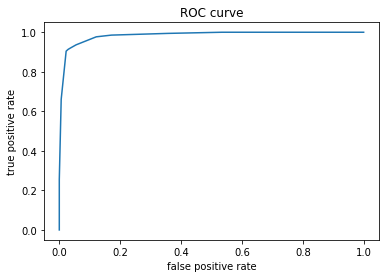

In [90]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
# y_pred=[]
# for i in range(0,1144,1):
#     y_pred.append(tree.predict(required_dftrainml.iloc[i].reshape(1,-1)))
y_pred=tree.predict(required_dftrainml)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_ml)
train_labels = le.transform(y_ml)

le.fit(y_ml)
train_labels1 = le.transform(y_pred)
train_labels,train_labels1
rf_probs = tree.predict_proba(required_dftrainml)[:,1]

fpr, tpr, thresholds = roc_curve(train_labels, rf_probs)

roc_auc = auc(fpr, tpr)
print ("Area under the ROC curve : ",  roc_auc)
import matplotlib.pyplot as plt
plt.plot(fpr,tpr)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC curve')

In [69]:
tree.predict([[49,0.053328076,0.050987268,0.050367775,0.055350342,2.119205665,2.428771508,2.477379535,1.894612551,0.428753319,0.345234709,0.332133075,0.489212744,1.314590961,1.368464286,1.37562833,1.268276827,1.054422753,1.177100978,1.183850018,0.959045065,3.298043567,3.339160074,3.346123603,3.262493781,0.07854194,-0.077518518,-0.053488969,-0.049426646,-0.098111467,0.48327082,0.409473265,0.394959624,0.534613731,0.585923316,0.562054835,0.555733355,0.60368517,7.841653404,7.842537851,7.842563752,7.840826051,2.240798721,2.212990661,2.208284116,2.261686743,5.300375134,4.98996526,4.941371145,5.52375481,1.854517795,1.854981295,1.854223466,1.854512806]]) 


array(['Viable'], dtype=object)